# Modeling

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV

import pickle

import os

In [2]:
cwd = os.getcwd()

PATH_TO_SAVE_TRAIN_DF_NO_OTLIERS = cwd + '/data/preprocessing/preproc_df_train_no.csv'
PATH_TO_SAVE_TRAIN_DF = cwd + '/data/preprocessing/preproc_df_train.csv'

PATH_TO_SAVE_TEST_DF = cwd + '/data/preprocessing/preproc_df_test.csv'
PATH_TO_SAVE_TEST_DF_NO_OTLIERS = cwd + '/data/preprocessing/preproc_df_test_no.csv'

PATH_TO_ROW_DATA = cwd + '/data/raw/sales_df_train.csv'

PATH_TO_SAVE_MODELS = cwd + '/models'

Создадим функцию для оценки качества

In [3]:
def wape(y_true: np.array, y_pred: np.array):
    if type(y_true) == pd.DataFrame:
        y_true = y_true.values.reshape(-1)
    elif type(y_true) != pd.Series:
        y_true = y_true.reshape(-1)
        
    if type(y_pred) == pd.DataFrame:
        y_pred = y_pred.values.reshape(-1)
    elif type(y_pred) != pd.Series:
        y_pred = y_pred.reshape(-1)
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

Поскольку нам нужно минимизировать наше значение, то преобразуем нашу функциюю в loss (для оптимизации в GridSearch)

In [4]:
wape_loss = make_scorer(wape, greater_is_better=False)

Так как нам нужно обучить разные модели на разных товарах, то будем создавать словарь с моделями, которые проверим на необработанных данных, которые модель не видела

## Создание моделей

Обуим нужное количество моделей (обучат будем в цикле, и сразу получать словарь с моделями)

In [17]:
dict_mod = {}
dict_skaler = {}
dict_score = {}
for i, name_mod in enumerate(list_mod):
    df_train_mod_0 = df_train[df_train['group_shop_cat'] == name_mod]
    df_train_mod_0 = df_train_mod_0.drop('group_shop_cat',axis=1)

    df_test_mod_0 = df_train_mod_0.loc['2023-07-05':'2023-07-06']
    df_train_mod_0 = df_train_mod_0.loc[:'2023-07-04']

    X_train_mod_0 = df_train_mod_0.drop(target_list, axis=1)
    X_test_mod_0 = df_test_mod_0.drop(target_list, axis=1)

    y_train_mod_0 = df_train_mod_0[target_list]
    y_test_mod_0 = df_test_mod_0[target_list]
    
#     scaler = StandardScaler()
#     X_train_mod_0 = scaler.fit_transform(X_train_mod_0)
#     X_test_mod_0 = scaler.transform(X_test_mod_0)
#     dict_skaler[name_mod] = scaler
    
#     model = LinearRegression()
    params = {
              'loss_function': 'MultiRMSE', 
              'eval_metric': 'MultiRMSE', 
             }

    model = CatBoostRegressor(**params, 
                              n_estimators=500, 
                              verbose=False)
    model.fit(X_train_mod_0, y_train_mod_0)
    
    if X_test_mod_0.shape[0] != 0:
        y_pred = model.predict(X_test_mod_0)
    
    dict_mod[name_mod] = model
    
    if X_test_mod_0.shape[0] != 0:
        dict_score[name_mod] = wape(y_test_mod_0, y_pred)
    else:
        dict_score[name_mod] = -1
    
#     print(f'Обучено {i + 1} моделей из {len(list_mod)}')

Напишем функцию, которая будет делать предсказания на основе датасета с датой с которой нужно сделать предсказание на 14 дней вперёд в формате указанном в ТЗ.

In [18]:
def get_predict(df, list_models, dict_mod):
    last_date = df.index.max()
    list_models = df.loc[last_date, 'group_shop_cat'].unique()

    list_columns = []
    for i in range(14):
        list_columns.append(last_date + timedelta(days=i))

    list_predict = []
    for name_model in list_models: 
        df_for_pred = df.loc[(df.index == last_date) & 
                                  (df['group_shop_cat'] == name_model)]    
        if df_for_pred.shape[0] > 0:
            X_test = df_for_pred.drop('target_0', axis=1)

            sku_df = df_for_pred.loc[last_date, 'pr_sku_id'].reset_index(drop=True)
            st_df = df_for_pred.loc[last_date, 'st_id'].reset_index(drop=True)
            pr_sales_type_df = df_for_pred.loc[last_date, 'pr_sales_type_id'].reset_index(drop=True)

            X_test = X_test.drop(['group_shop_cat', 'pr_sku_id', 'st_id', 'pr_group_id'],axis=1)

            model = dict_mod[name_model]
#             scaler = dict_skaler[name_model]
#             X_test = scaler.transform(X_test)
            
            y_pred = model.predict(X_test)

            predictions_data = pd.DataFrame(data=y_pred, columns=list_columns)

            predictions_data['pr_sku_id'] = sku_df
            predictions_data['st_id'] = st_df
            predictions_data['pr_sales_type_id'] = pr_sales_type_df

            predictions_data = predictions_data.melt(['st_id', 'pr_sku_id', 'pr_sales_type_id'], 
                                                     var_name='date', 
                                                     value_name='target')
            list_predict.append(predictions_data)


    return pd.concat(list_predict)

Загрузим тестовый датасет, получим из него данные за 2023-07-05 (чтобы можно было проверить результат с данными)

In [19]:
df_test = pd.read_csv(PATH_TO_SAVE_TEST_DF_NO_OTLIERS, index_col=0)
df_test.index = pd.to_datetime(df_test.index)
date = '2023-07-05'
df_test = df_test.loc[date]
list_models = df_test['group_shop_cat'].unique()

In [20]:
pred = get_predict(df_test, list_models, dict_mod)

In [21]:
pred.head()

,st_id,pr_sku_id,pr_sales_type_id,date,target
0,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,0.0,2023-07-05,0.284911
1,084a8a9aa8cced9175bd07bc44998e75,88feeeb024d3f69da7322d76b7b53744,0.0,2023-07-05,0.134664
2,084a8a9aa8cced9175bd07bc44998e75,be8d2843456cac871fc116ab25d02994,0.0,2023-07-05,0.134664
3,084a8a9aa8cced9175bd07bc44998e75,c2718cfd2edcbadfe0162a4f4c91f3a0,0.0,2023-07-05,0.019275
4,1ecfb463472ec9115b10c292ef8bc986,00b72c2f01a1512cbb1d3f33319bac93,0.0,2023-07-05,3.827962


Для получения реального качества модели возьмём сырые данные и сделаем срез от стартовой даты прогноза

In [22]:
df_y_test = pd.read_csv(PATH_TO_ROW_DATA)[['pr_sku_id', 'st_id', 'pr_sales_in_units', 'date', 'pr_sales_type_id']]
df_y_test['date'] = pd.to_datetime(df_y_test['date'])
df_y_test = df_y_test.rename(columns={'pr_sales_in_units':'y_true'})
df_y_test = df_y_test.loc[df_y_test['date'] >= date]

Присоединим целевой признак к нашем данным и посчитаем WAPE

In [23]:
pred = pred.merge(df_y_test, on=['st_id', 'pr_sku_id', 'date', 'pr_sales_type_id'], how='left')
pred = pred.fillna(0)

In [24]:
wape(pred['y_true'], pred['target'])

1.5301518100183058

Визуализируем прогноз и целевой признак, отрисуем по всем товарам средне значение за день.

In [25]:
p = pred.groupby('date')[['target', 'y_true']].agg('mean').reset_index()

In [26]:
p.index = p['date']

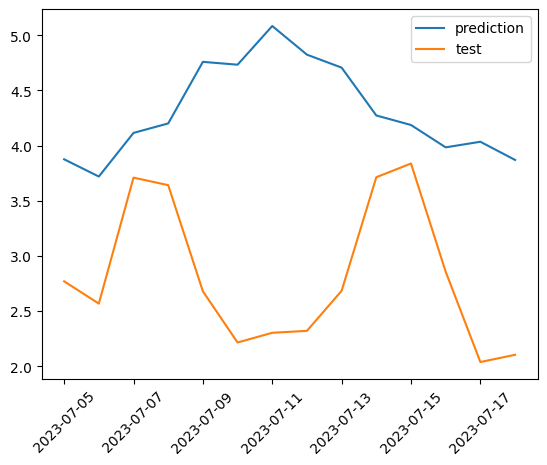

In [27]:
plt.plot(p['target'], label='prediction')
plt.plot(p['y_true'], label='test')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Сохраним получившиеся модели

In [28]:
for k in dict_mod.keys():
    path_save = f'{PATH_TO_SAVE_MODELS}/{k}.pkl'
    with open(path_save, "wb") as f:
        pickle.dump(dict_mod[k], f)

### Подбор гиперпараметров

In [29]:
#Доделать

In [17]:
params = {'max_depth': range(10, 30, 10),
         'n_estimators': range(200, 500, 100)}
estimator = RandomForestRegressor(random_state=123)
index_num = X_train_mod_0[:'2023-07-01'].shape[0]
folds = [([i for i in range(index_num)], 
          [index_num + 1, index_num + 2])]


In [18]:
gs = GridSearchCV(estimator=estimator,
                  param_grid=params,
                  cv=folds,
                  scoring=wape_loss)

gs.fit(X_train_mod_0, y_train_mod_0)

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1526, 1527])],
             estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_depth': range(10, 30, 10),
                         'n_estimators': range(200, 500, 100)},
             scoring=make_scorer(wape, greater_is_better=False))

In [19]:
gs.best_params_

{'max_depth': 20, 'n_estimators': 400}

In [20]:
gs.best_score_

-0.09731663581524701

# Визуализация и т.д.

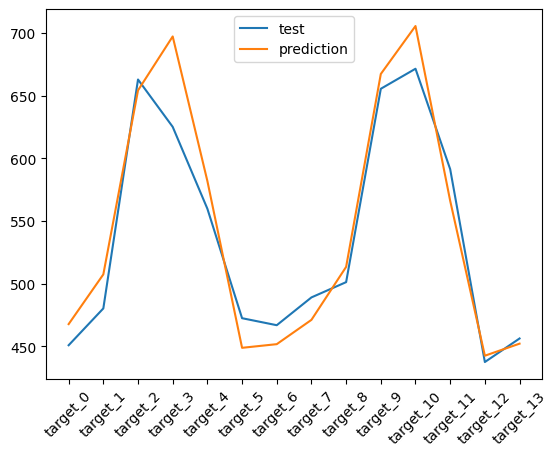

In [21]:
plt.plot(y_test_mod_0.mean(), label='test')
plt.plot(predictions_data.mean(), label='prediction')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [22]:
list_day=[]
for i in range(0, 14):
    day = datetime.strptime('2023-07-04', '%Y-%m-%d') + timedelta(days=i)
    list_day.append(datetime.strftime(day, '%Y-%m-%d'))

In [23]:
predict_ser = pd.Series(predictions_data.iloc[0].values, index=list_day)
y_test_ser = pd.Series(y_test_mod_0.iloc[0].values, index=list_day)

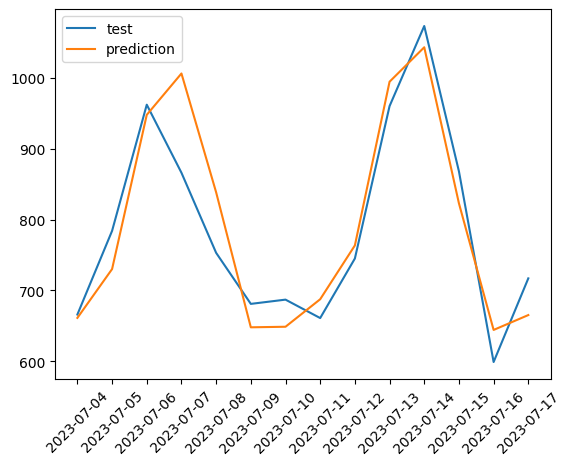

In [24]:
plt.plot(y_test_ser, label='test')
plt.plot(predict_ser, label='prediction')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Веса линейной модели

In [25]:
pd.DataFrame(data=lin_mod.coef_, columns= X_train_mod_0.columns).style.background_gradient(cmap='Blues')

,weekend,rolling_mean_30,ratio,mean_in_weekday_4_week,rolling_mean_7,rolling_max_7,rolling_min_7,rolling_max_min_7,rolling_ratio_7,rolling_mean_14,rolling_max_14,rolling_min_14,rolling_max_min_14,rolling_ratio_14,rolling_max_30,rolling_min_30,rolling_max_min_30,rolling_ratio_30,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,mean_week_lag,new_year,easter,week_after_new_year,week_after_easter,week_befor_new_year,week_befor_easter,holiday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,st_city_id_3202111cf90e7c816a472aaceb72b0df,st_city_id_885fe656777008c335ac96072a45be15,st_city_id_908c9a564a86426585b29f5335b619bc,st_city_id_955d864a62659945cc9434898e275deb,st_city_id_b8b4b727d6f5d1b61fff7be687f7970f,st_city_id_c1f75cc0f7fe269dd0fd9bd5e24f9586,st_division_code_296bd0cc6e735f9d7488ebc8fbc19130,st_division_code_32586311f16876abf92901085bd87b99,st_division_code_429a86ff6336c144ddaf6144f52ab52c,st_division_code_81b4dd343f5880df806d4c5d4a846c64,st_division_code_da742b3cfca5388aaf9af28a726a3c30,st_division_code_e26072c92d8fe0738df44d571d5f5e8b,st_type_format_id_1,st_type_format_id_2,st_type_format_id_4,st_type_loc_id_1,st_type_loc_id_2,st_type_loc_id_3,st_type_size_id_8,st_type_size_id_12,st_type_size_id_19,st_type_size_id_20,st_type_size_id_28,st_type_size_id_32,mean_seale_1,mean_seale_2,mean_seale_3,mean_seale_4
0,-175768524596.710358,-0.540282,-146.445587,0.344728,0.133288,-0.051547,0.095407,0.025589,40.277613,0.106953,-0.059034,-0.192623,-0.101273,59.230759,0.000435,0.035194,0.052269,-15.292084,0.563904,0.033005,0.132088,0.029266,0.040962,0.150995,-0.083191,0.013077,0.016518,0.011620,0.022018,0.004164,0.103535,0.001965,0.032063,-1207.895072,-192.545037,-79.679946,0.000001,333.712023,26.699389,40.071641,-50219578559.714157,-50219578484.258957,-50219578471.773315,-50219578474.571854,-50219578359.542137,125548946222.035324,125548946127.827393,0.000000,-0.968806,1.561552,0.000000,-3.779241,3.186787,2.217688,0.000000,1.561550,0.000000,-3.779238,0.000000,0.000000,0.000000,0.000000,-3.186907,3.186796,0.000000,4.748083,-4.748086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.613165,10.613156
1,563790923644.147705,0.010911,-76.388666,0.178398,0.153794,-0.423836,0.148808,-0.149289,404.765646,0.029110,-0.151787,-0.366539,-0.337990,126.603729,0.003540,-0.043335,-0.130463,38.768860,0.090485,0.201385,0.225952,0.194901,0.279480,0.176454,0.118652,0.066620,0.037155,0.048935,0.022812,0.141010,0.145756,0.123898,0.205046,461.648925,-50.238804,240.067563,-0.000004,561.821782,19.247911,-55.825658,161083120998.838257,161083120986.827881,161083120979.466736,161083121119.255585,161083121163.501892,-402707802569.863342,-402707802678.034363,0.000000,5.271797,-9.906137,0.000000,-2.358530,6.991941,12.264667,0.000000,-9.906130,0.000000,-2.358544,0.000000,0.000000,0.000000,0.000000,-6.991554,6.991909,0.000000,-2.913375,2.913385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-30.084395,30.084423
2,-526498082958.364136,0.050161,-76.649036,-0.020282,0.047982,-0.026628,0.300312,0.147859,0.461876,0.145658,-0.194916,-0.267166,-0.157379,115.697113,-0.034973,0.002213,0.086868,-38.336639,-0.210022,0.013428,0.013885,0.189346,0.074661,0.021055,0.036560,0.067902,0.041153,-0.004349,0.103996,0.141468,0.063158,0.118032,0.031485,484.164597,-67.206857,28.025479,0.000004,593.899912,17.313888,-23.349112,-150428023737.407806,-150428023777.498444,-150428023640.757660,-150428023571.023438,-150428023678.037262,376070059190.696838,376070059214.034363,0.000000,-6.323233,4.307369,0.000000,-8.534107,10.550841,4.226739,0.000000,4.307363,0.000000,-8.534098,0.000000,0.000000,0.000000,0.000000,-10.551208,10.550878,0.000000,14.857448,-14.857456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-35.580109,35.580086
3,1024687517622.468384,0.285394,52.322020,-0.107982,-0.054540,0.084816,0.236975,0.139349,-51.785786,-0.149693,-0.086273,-0.092484,-0.232651,120.733215,0.055084,0.116882,-0.114716,-42.166992,-0.2561